In [1]:
from functools import partial

from keras.models import Model
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import Lambda
from keras.layers import MaxPooling2D
from keras.layers import add
from keras import backend as K


def scaling(x, scale):
    return x * scale


def conv2d_bn(x,
              filters,
              kernel_size,
              strides=1,
              padding='same',
              activation='relu',
              use_bias=False,
              name=None):
    x = Conv2D(filters,
               kernel_size,
               strides=strides,
               padding=padding,
               use_bias=use_bias,
               name=name)(x)
    if not use_bias:
        bn_axis = 1 if K.image_data_format() == 'channels_first' else 3
        bn_name = _generate_layer_name('BatchNorm', prefix=name)
        x = BatchNormalization(axis=bn_axis, momentum=0.995, epsilon=0.001,
                               scale=False, name=bn_name)(x)
    if activation is not None:
        ac_name = _generate_layer_name('Activation', prefix=name)
        x = Activation(activation, name=ac_name)(x)
    return x


def _generate_layer_name(name, branch_idx=None, prefix=None):
    if prefix is None:
        return None
    if branch_idx is None:
        return '_'.join((prefix, name))
    return '_'.join((prefix, 'Branch', str(branch_idx), name))


def _inception_resnet_block(x, scale, block_type, block_idx, activation='relu'):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else 3
    if block_idx is None:
        prefix = None
    else:
        prefix = '_'.join((block_type, str(block_idx)))
    name_fmt = partial(_generate_layer_name, prefix=prefix)

    if block_type == 'Block35':
        branch_0 = conv2d_bn(x, 32, 1, name=name_fmt('Conv2d_1x1', 0))
        branch_1 = conv2d_bn(x, 32, 1, name=name_fmt('Conv2d_0a_1x1', 1))
        branch_1 = conv2d_bn(branch_1, 32, 3, name=name_fmt('Conv2d_0b_3x3', 1))
        branch_2 = conv2d_bn(x, 32, 1, name=name_fmt('Conv2d_0a_1x1', 2))
        branch_2 = conv2d_bn(branch_2, 32, 3, name=name_fmt('Conv2d_0b_3x3', 2))
        branch_2 = conv2d_bn(branch_2, 32, 3, name=name_fmt('Conv2d_0c_3x3', 2))
        branches = [branch_0, branch_1, branch_2]
    elif block_type == 'Block17':
        branch_0 = conv2d_bn(x, 128, 1, name=name_fmt('Conv2d_1x1', 0))
        branch_1 = conv2d_bn(x, 128, 1, name=name_fmt('Conv2d_0a_1x1', 1))
        branch_1 = conv2d_bn(branch_1, 128, [1, 7], name=name_fmt('Conv2d_0b_1x7', 1))
        branch_1 = conv2d_bn(branch_1, 128, [7, 1], name=name_fmt('Conv2d_0c_7x1', 1))
        branches = [branch_0, branch_1]
    elif block_type == 'Block8':
        branch_0 = conv2d_bn(x, 192, 1, name=name_fmt('Conv2d_1x1', 0))
        branch_1 = conv2d_bn(x, 192, 1, name=name_fmt('Conv2d_0a_1x1', 1))
        branch_1 = conv2d_bn(branch_1, 192, [1, 3], name=name_fmt('Conv2d_0b_1x3', 1))
        branch_1 = conv2d_bn(branch_1, 192, [3, 1], name=name_fmt('Conv2d_0c_3x1', 1))
        branches = [branch_0, branch_1]
    else:
        raise ValueError('Unknown Inception-ResNet block type. '
                         'Expects "Block35", "Block17" or "Block8", '
                         'but got: ' + str(block_type))

    mixed = Concatenate(axis=channel_axis, name=name_fmt('Concatenate'))(branches)
    up = conv2d_bn(mixed,
                   K.int_shape(x)[channel_axis],
                   1,
                   activation=None,
                   use_bias=True,
                   name=name_fmt('Conv2d_1x1'))
    up = Lambda(scaling,
                output_shape=K.int_shape(up)[1:],
                arguments={'scale': scale})(up)
    x = add([x, up])
    if activation is not None:
        x = Activation(activation, name=name_fmt('Activation'))(x)
    return x


def InceptionResNetV1(input_shape=(160, 160, 3),
                      classes=128,
                      dropout_keep_prob=0.8,
                      weights_path=None):
    inputs = Input(shape=input_shape)
    x = conv2d_bn(inputs, 32, 3, strides=2, padding='valid', name='Conv2d_1a_3x3')
    x = conv2d_bn(x, 32, 3, padding='valid', name='Conv2d_2a_3x3')
    x = conv2d_bn(x, 64, 3, name='Conv2d_2b_3x3')
    #x = MaxPooling2D(3, strides=2, name='MaxPool_3a_3x3')(x)
    x = conv2d_bn(x, 80, 1, padding='valid', name='Conv2d_3b_1x1')
    x = conv2d_bn(x, 192, 3, padding='valid', name='Conv2d_4a_3x3')
    #x = conv2d_bn(x, 256, 3, strides=2, padding='valid', name='Conv2d_4b_3x3')

    # 5x Block35 (Inception-ResNet-A block):
    for block_idx in range(1, 6):
        x = _inception_resnet_block(x,
                                    scale=0.17,
                                    block_type='Block35',
                                    block_idx=block_idx)

    # Mixed 6a (Reduction-A block):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else 3
    name_fmt = partial(_generate_layer_name, prefix='Mixed_6a')
    branch_0 = conv2d_bn(x,
                         384,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 0))
    branch_1 = conv2d_bn(x, 192, 1, name=name_fmt('Conv2d_0a_1x1', 1))
    branch_1 = conv2d_bn(branch_1, 192, 3, name=name_fmt('Conv2d_0b_3x3', 1))
    branch_1 = conv2d_bn(branch_1,
                         256,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 1))
    branch_pool = MaxPooling2D(3,
                               strides=2,
                               padding='valid',
                               name=name_fmt('MaxPool_1a_3x3', 2))(x)
    branches = [branch_0, branch_1, branch_pool]
    x = Concatenate(axis=channel_axis, name='Mixed_6a')(branches)

    # 10x Block17 (Inception-ResNet-B block):
    for block_idx in range(1, 11):
        x = _inception_resnet_block(x,
                                    scale=0.1,
                                    block_type='Block17',
                                    block_idx=block_idx)

    # Mixed 7a (Reduction-B block): 8 x 8 x 2080
    name_fmt = partial(_generate_layer_name, prefix='Mixed_7a')
    branch_0 = conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 0))
    branch_0 = conv2d_bn(branch_0,
                         384,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 0))
    branch_1 = conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 1))
    branch_1 = conv2d_bn(branch_1,
                         256,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 1))
    branch_2 = conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 2))
    branch_2 = conv2d_bn(branch_2, 256, 3, name=name_fmt('Conv2d_0b_3x3', 2))
    branch_2 = conv2d_bn(branch_2,
                         256,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 2))
    branch_pool = MaxPooling2D(3,
                               strides=2,
                               padding='valid',
                               name=name_fmt('MaxPool_1a_3x3', 3))(x)
    branches = [branch_0, branch_1, branch_2, branch_pool]
    x = Concatenate(axis=channel_axis, name='Mixed_7a')(branches)

    # 5x Block8 (Inception-ResNet-C block):
    for block_idx in range(1, 6):
        x = _inception_resnet_block(x,
                                    scale=0.2,
                                    block_type='Block8',
                                    block_idx=block_idx)
    x = _inception_resnet_block(x,
                                scale=1.,
                                activation=None,
                                block_type='Block8',
                                block_idx=6)

    # Classification block
    x = GlobalAveragePooling2D(name='AvgPool')(x)
    x = Dropout(1.0 - dropout_keep_prob, name='Dropout')(x)
    # Bottleneck
    x = Dense(classes, use_bias=False, name='Bottleneck')(x)
    bn_name = _generate_layer_name('BatchNorm', prefix='Bottleneck')
    x = BatchNormalization(momentum=0.995, epsilon=0.001, scale=False,
                           name=bn_name)(x)

    # Create model
    model = Model(inputs, x, name='inception_resnet_v1')
    if weights_path is not None:
        model.load_weights(weights_path)

    return model

Using TensorFlow backend.


In [2]:
model = InceptionResNetV1(input_shape=(32,32,3), classes=10,
                      dropout_keep_prob=0.1,
                      weights_path=None)














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.890045 to fit
tcmalloc: large alloc 1556701184 bytes == 0x564dd7dec000 @  0x7fe557bfe001 0x7fe553e951fa 0x7fe553e952ad 0x7fe5550206df 0x7fe555517261 0x7fe557994468 0x7fe557996d53 0x564dd506c092 0x7fe557349b97 0x564dd506c12a

Height =32767, Width =11877, Channels =3


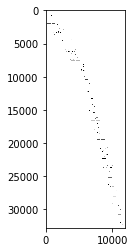

In [3]:
import tensorflow
tensorflow.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt

im = cv2.imread('model_plot.png')
height, width, channels = im.shape
print("Height =%d, Width =%d, Channels =%d"%(height,width,channels))
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
import keras
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [5]:
from tensorflow.keras.datasets import cifar10
#(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


from termcolor import colored
def show_shapes(x_train, y_train, x_test, y_test, color='green'):
    print(colored('Training shape:', color, attrs=['bold']))
    print('  x_train.shape:', x_train.shape)
    print('  y_train.shape:', y_train.shape)
    print(colored('\nTesting shape:', color, attrs=['bold']))
    print('  x_test.shape:', x_test.shape)
    print('  y_test.shape:', y_test.shape)

show_shapes(x_train, y_train, x_test, y_test)

Training shape:
  x_train.shape: (50000, 32, 32, 3)
  y_train.shape: (50000, 1)

Testing shape:
  x_test.shape: (10000, 32, 32, 3)
  y_test.shape: (10000, 1)


In [6]:
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

#(x_train, y_train), (x_test, y_test)
batch_size = 32
epochs = 20
NUM_CLASSES = 10
print(y_train.shape)
#y_train = to_categorical(y_train, NUM_CLASSES)
#y_test = to_categorical(y_test, NUM_CLASSES)
print(y_train.shape)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

import os, os.path,shutil
base_dir = 'Data'
os.makedirs(base_dir, exist_ok=True)

checkpoint = ModelCheckpoint(base_dir+ "Best_Weights.h5", monitor='val_acc',
                             verbose=1,save_best_only=True, mode='auto',
                             period=1)

history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_test, y_test),
                verbose=1,
                callbacks=[checkpoint],
                shuffle=True)

(50000, 1)
(50000, 1)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 211s 4ms/step - loss: 2.6426 - acc: 0.1051 - val_loss: 2.3491 - val_acc: 0.0916

Epoch 00001: val_acc improved from -inf to 0.09160, saving model to DataBest_Weights.h5
Epoch 2/20
50000/50000 [==============================] - 185s 4ms/step - loss: 2.4226 - acc: 0.1037 - val_loss: 2.3048 - val_acc: 0.1032

Epoch 00002: val_acc improved from 0.09160 to 0.10320, saving model to DataBest_Weights.h5
Epoch 3/20
50000/50000 [==============================] - 186s 4ms/step - loss: 2.3491 - acc: 0.1003 - val_loss: 2.3045 - val_acc: 0.0821

Epoch 00003: val_acc did not improve from 0.10320
Epoch 4/20
50000/50000 [==============================] - 186s 4ms/step - loss: 2.3230 - acc: 0.0947 - val_loss: 2.3140 - val_acc: 0.0907

Epoch 00004: val_acc did not improve from 0.103

KeyboardInterrupt: ignored

In [7]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored

In [8]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
model.load_weights("DataBest_Weights.h5")
predict = model.predict(x_test)
print(predict.shape)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = y_test, y_pred = predict.argmax(axis=1))
print(cm)

from sklearn.metrics import classification_report
print(classification_report(y_test, predict.argmax(axis=1)))

(10000, 10)
[[165 213   0   0  13   7   0   0   0 602]
 [ 34 278   0   0   9   1   0   0   0 678]
 [ 42 212   0   0  12   2   0   0   0 732]
 [  7 197   0   0   2   3   0   0   0 791]
 [  9 165   0   0   4   1   0   0   0 821]
 [ 15 258   0   0   4   1   0   0   0 722]
 [  0 109   0   0   3   0   0   0   0 888]
 [  9 167   0   0   3   0   0   0   0 821]
 [ 84 267   0   0  19   1   0   0   0 629]
 [ 18 217   0   0   5   0   0   0   0 760]]
              precision    recall  f1-score   support

           0       0.43      0.17      0.24      1000
           1       0.13      0.28      0.18      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.05      0.00      0.01      1000
           5       0.06      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
